In [392]:
from qiskit import *
import numpy as np

from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from scipy.optimize import minimize
from qiskit.providers.fake_provider import FakeToronto
import time

provider=IBMQ.load_account()
times = {
    "rx": {
        3: [],
        4: [],
        5: [],
        6: [],
    },
    "had": {
        3: [],
        4: [],
        5: [],
        6: [],
    }
}

ibmqfactory.load_account:WARNING:2022-12-04 23:55:31,567: Credentials are already in use. The existing account in the session will be replaced.


In [393]:
def QAOA_Vertex_Cover(connections,gamma,beta):
    n=max(map(max, connections))+1
    qc=QuantumCircuit(n+1,n)


    qc.x(n)
    qc.h(range(n))
    
    
    qc.barrier()
    for i in connections:
        qc.cp(-1*gamma,i,n)
        qc.mcp(gamma,i,n)

        
    qc.barrier()


    for i in range(n):
        qc.x(i)
        qc.cp(-1*gamma,i,n)
        qc.x(i)


    qc.barrier()


    qc.rx(2*beta, range(n))


    qc.measure(range(n),range(n))

    return qc

def QAOA_Vertex_Cover_had(connections,gamma,beta):
    n=max(map(max, connections))+1
    qc=QuantumCircuit(n+1,n)


    qc.x(n)
    qc.h(range(n))
    
    
    qc.barrier()
    for i in connections:
        qc.cp(-1*gamma,i,n)
        qc.mcp(gamma,i,n)

        
    qc.barrier()


    for i in range(n):
        qc.x(i)
        qc.cp(-1*gamma,i,n)
        qc.x(i)


    qc.barrier()


    qc.rx(2/np.sqrt(2)*beta, range(n))
    qc.rz(2/np.sqrt(2)*beta, range(n))


    qc.measure(range(n),range(n))

    return qc




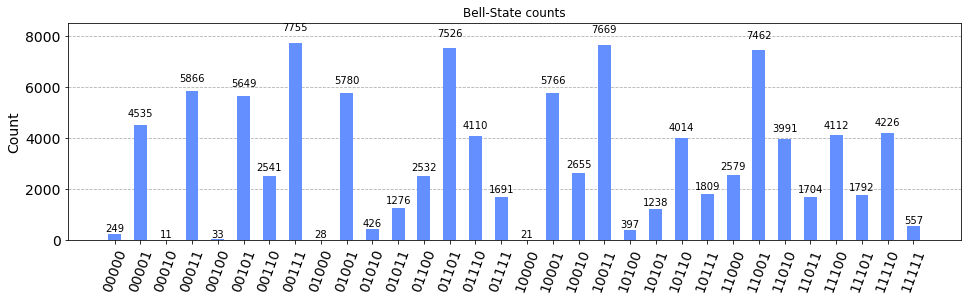

In [394]:
connections=[[0,1],[0,2],[0,3],[0,4],[1,3],[2,4]]
#gamma=[0,2pi], beta=[0,pi], gamma1<gamma2

gamma=np.pi*7/4
beta=np.pi*3.5/4
qc=QAOA_Vertex_Cover(connections,gamma,beta)

qc.draw()

backend = Aer.get_backend('aer_simulator')
circ = transpile(qc, backend)

# Run and get counts
#result = simulator.run(circ,shots=100000).result()
#counts = result.get_counts(circ)
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, title='Bell-State counts',figsize=(16,4))

In [395]:
class graph:
    def __init__(self, _graph=None):
        if _graph is None:
            _graph = {}
        self._graph = _graph
      
    def getVertices(self):
        return list(self._graph.keys())
    
    def printVertices(self):
        print(self.getVertices())
    
    def getEdges(self):
        edgename = []
        for vrtx in self._graph:
            for nxtvrtx in self._graph[vrtx]:
                if {nxtvrtx, vrtx} not in edgename:
                    edgename.append({vrtx, nxtvrtx})
        ret_list = []
        for i in range(len(edgename)):
            ret_list.append([])
            for j in edgename[i]:
                ret_list[i].append(j)
        return ret_list
    
    def printEdges(self):
        print(self.getEdges())
        
    def getGraph(self):
        return self._graph
    
    def make_graph_from_connections(self, connections):
        vertexs = []
        graph_dict = {}
        for edge_list in connections:
            for vertex in edge_list:
                if vertex not in vertexs:
                    vertexs.append(vertex)
                    
        for vertex in vertexs:
            graph_dict[vertex] = []
            
        for edge_list in connections:
            if edge_list[1] not in graph_dict[edge_list[0]]:
                graph_dict[edge_list[0]].append(edge_list[1])
                
            if edge_list[0] not in graph_dict[edge_list[1]]:
                graph_dict[edge_list[1]].append(edge_list[0])
                
        self._graph = graph_dict
        
    def printGraph(self):
        print(self._graph)
          
    

In [396]:
g = graph()
g.make_graph_from_connections(connections)
g.printEdges()
g.printVertices()
g.printGraph()

[[0, 1], [0, 2], [0, 3], [0, 4], [1, 3], [2, 4]]
[0, 1, 2, 3, 4]
{0: [1, 2, 3, 4], 1: [0, 3], 2: [0, 4], 3: [0, 1], 4: [0, 2]}


In [397]:
def mvc_obj(bitstring, graph):
    obj1 = 0
    obj2 = 0
    
    for i in range(len(bitstring)):
        if bitstring[i] == '0':
            obj1 -= 1
    
    connections = graph.getEdges()
    for vtx in connections:
        if bitstring[vtx[0]] == '1' or bitstring[vtx[1]] == '1':
            obj2 -= 1
        
    return obj1 + (obj2*1.2)

def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = mvc_obj(bitstring[::-1], graph)
        avg += obj*count
        sum_count += count
    
    return avg/sum_count


def get_expectation(graph, backend, shots=100000):
    #simulator = Aer.get_backend('aer_simulator')
    backend.shots = shots
    connections = graph.getEdges()
            
    def execute_circ(theta):
        
        qc = QAOA_Vertex_Cover(connections,theta[0],theta[1])
        circ = transpile(qc, backend)
        res = backend.run(circ,shots).result()
        #rx_times.append(res.time_taken())
        counts = res.get_counts()
        
        return compute_expectation(counts, graph)
    
    return execute_circ

def get_expectation_had(graph, backend, shots=100000):
    #simulator = Aer.get_backend('aer_simulator')
    backend.shots = shots
    connections = graph.getEdges()
            
    def execute_circ_had(theta):
        
        qc = QAOA_Vertex_Cover_had(connections,theta[0],theta[1])
        circ = transpile(qc, backend)
        res = backend.run(circ,shots).result()
        #ry_times.append(res.time_taken())
        counts = res.get_counts()
        
        return compute_expectation(counts, graph)
    
    return execute_circ_had
    

# Testing on aer_simulator backend

In [398]:
backend = Aer.get_backend('aer_simulator')

# Rx Mixer

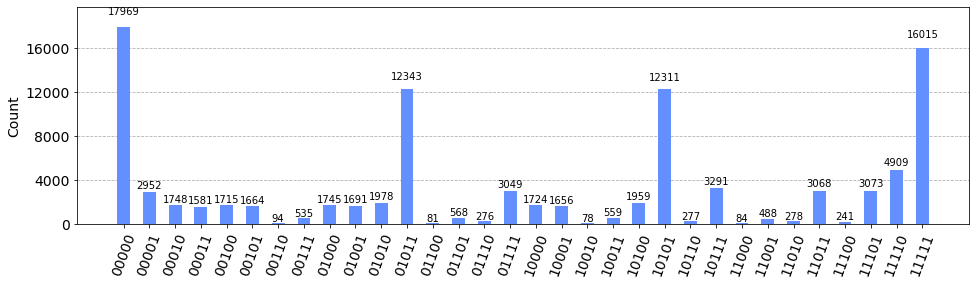

In [399]:
gamma=5
beta=2
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 7.075279839517962 ,Beta Pre-Otimization: 2 ,Beta Post-Optimization: 3.558300582089267


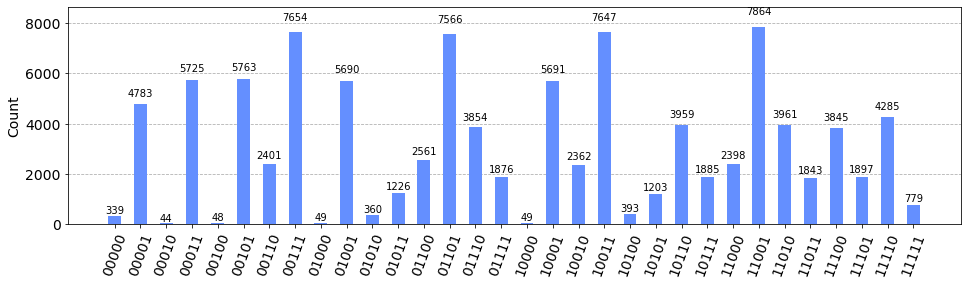

In [400]:
gamma=5
beta=2
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
#times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

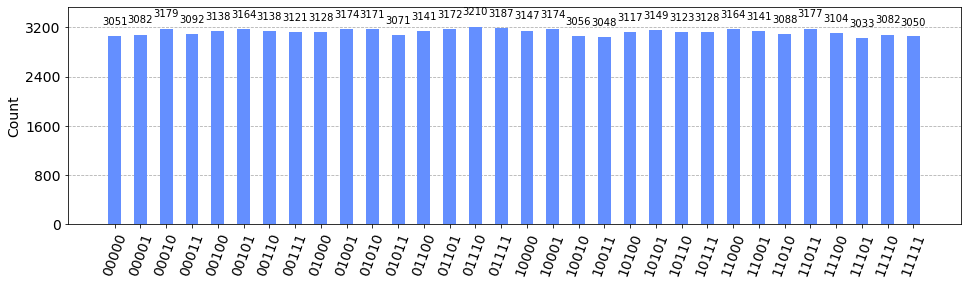

In [401]:
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 1.1704055516525778 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 0.4089757450928093


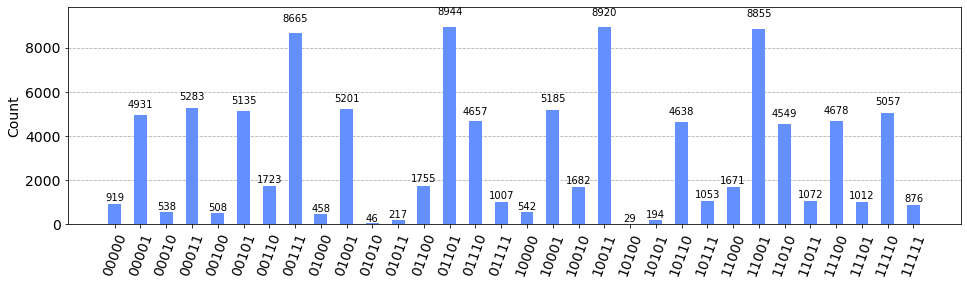

In [402]:
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [403]:
graph2_dict = {
    0: [2,4],
    1: [2],
    2: [0,1,3],
    3: [2],
    4: [0]
}
g2 = graph(graph2_dict)
print(g2.getEdges())

[[0, 2], [0, 4], [1, 2], [2, 3]]


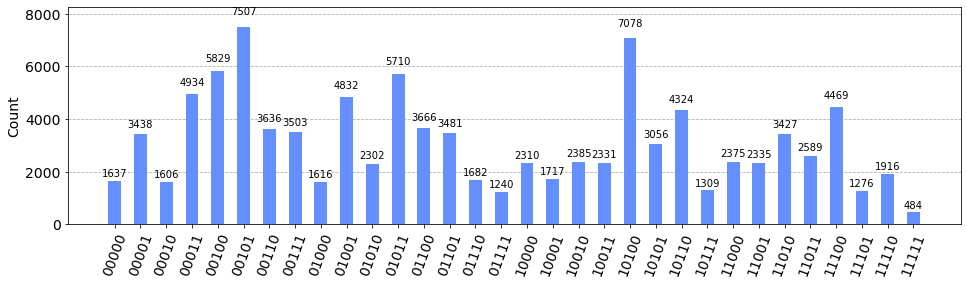

In [404]:
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g2.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.6491883301796975 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.657682637559926


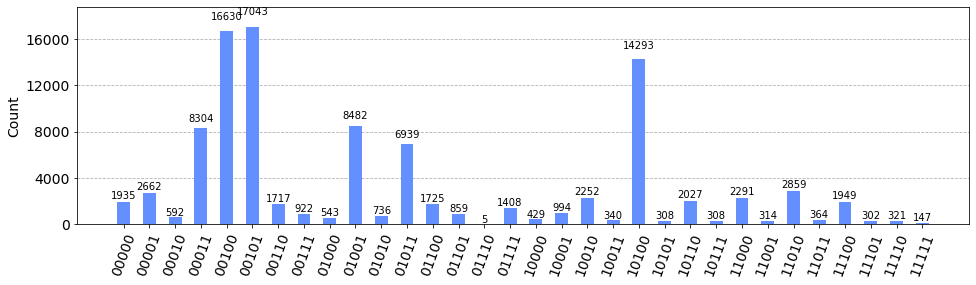

In [405]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g2, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g2.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
#times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [406]:
graph3_dict = {
    0: [1,2],
    1: [0],
    2: [0,3],
    3: [2],
}
g3 = graph(graph3_dict)
print(g3.getEdges())

[[0, 1], [0, 2], [2, 3]]


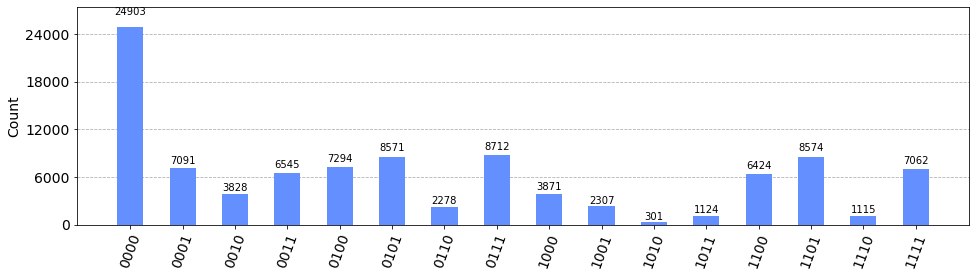

In [407]:
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 0.9383633320484154 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 2.0105959652020537


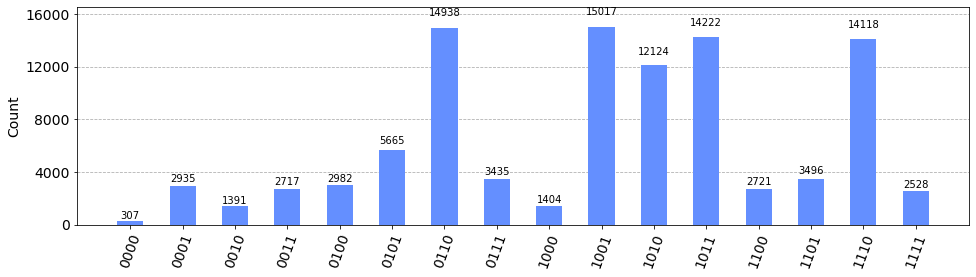

In [408]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [409]:
graph4_dict = {
    0: [3],
    1: [4],
    2: [5],
    3: [0,4],
    4: [1,3,5],
    5: [2,4]
}
g4 = graph(graph4_dict)
print(g4.getEdges())

[[0, 3], [1, 4], [2, 5], [3, 4], [4, 5]]


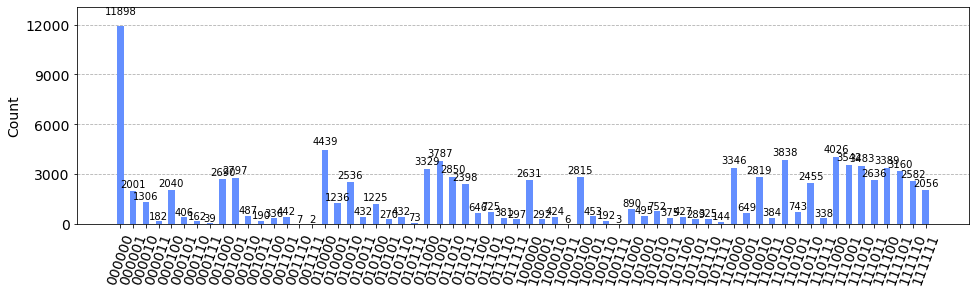

In [410]:
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.9312613047378389 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 2.1043698763063423


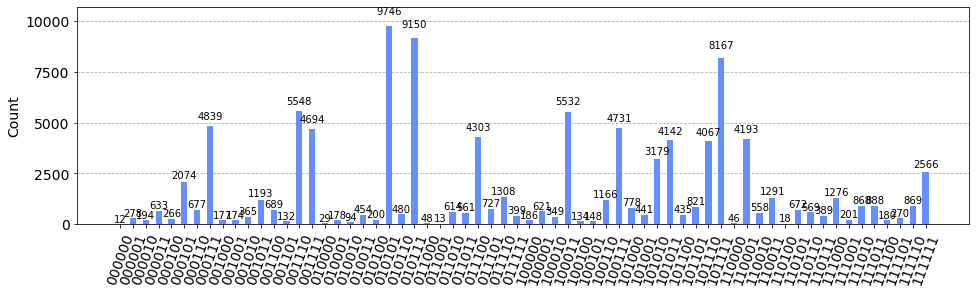

In [411]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

In [412]:
graph5_dict = {
    0: [1],
    1: [0,2],
    2: [1],
}
g5 = graph(graph5_dict)
print(g5.getEdges())

[[0, 1], [1, 2]]


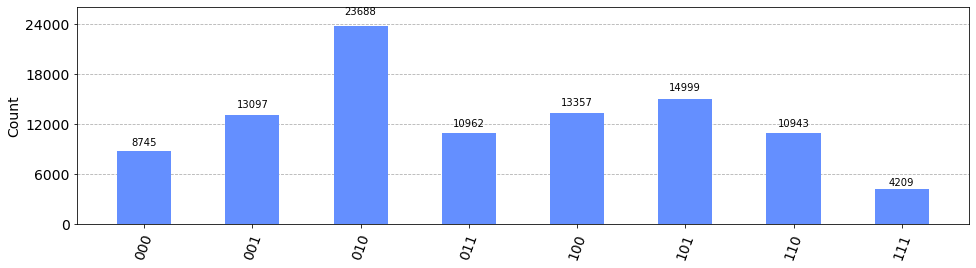

In [413]:
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.775739467465406 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.6076804220048078


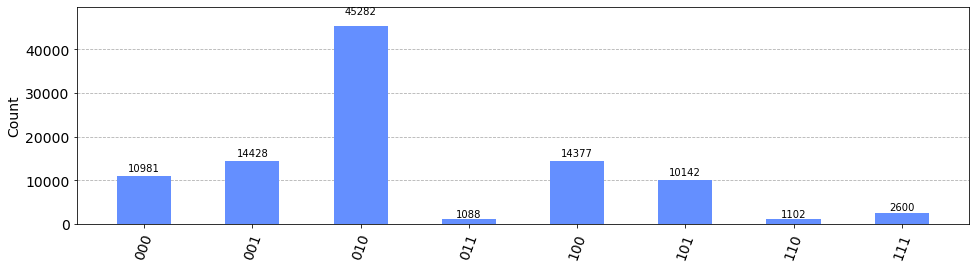

In [414]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Hadamard Mixer

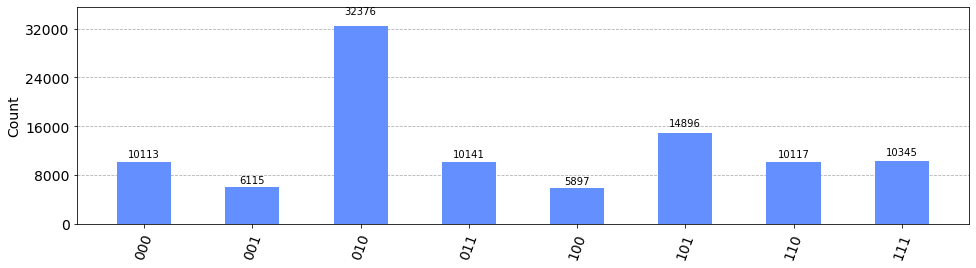

In [415]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.430980821615411 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.7595776038526574


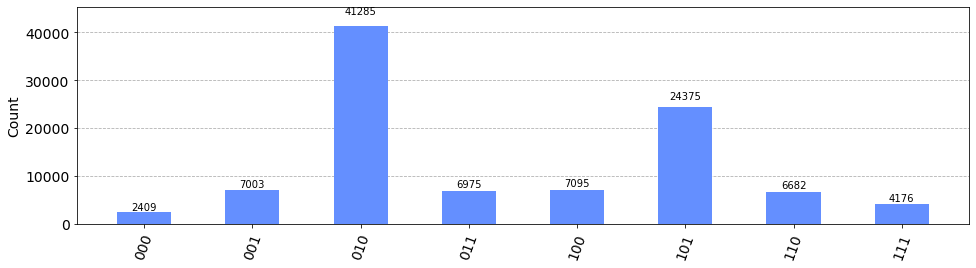

In [416]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_had(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

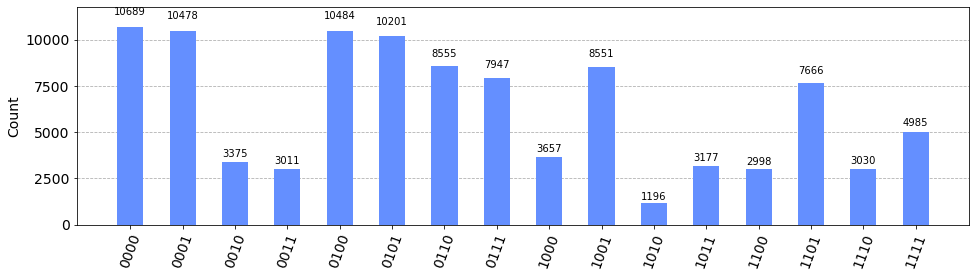

In [417]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.92011426627101 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.4665277899537046


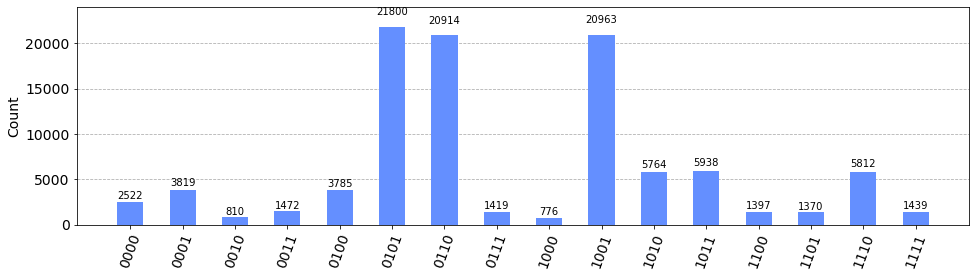

In [418]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

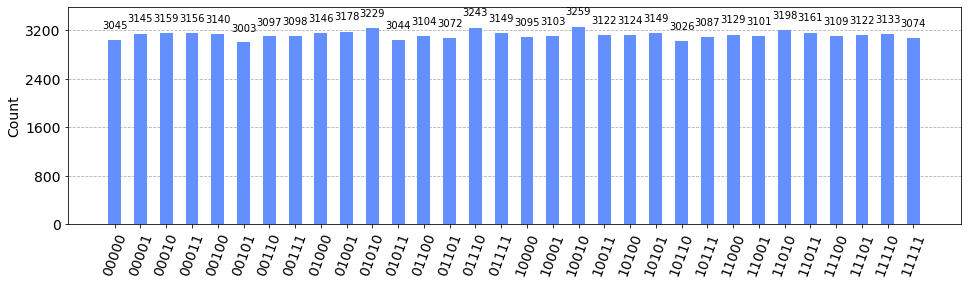

In [419]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 1.4675669620329048 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 1.8525805486205627


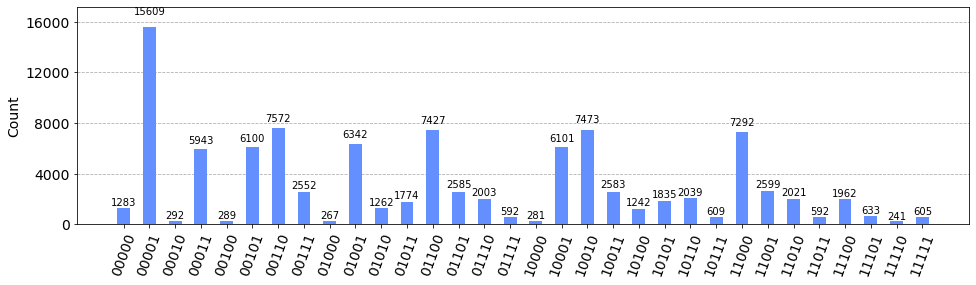

In [420]:
# 5 qubits
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation_had(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

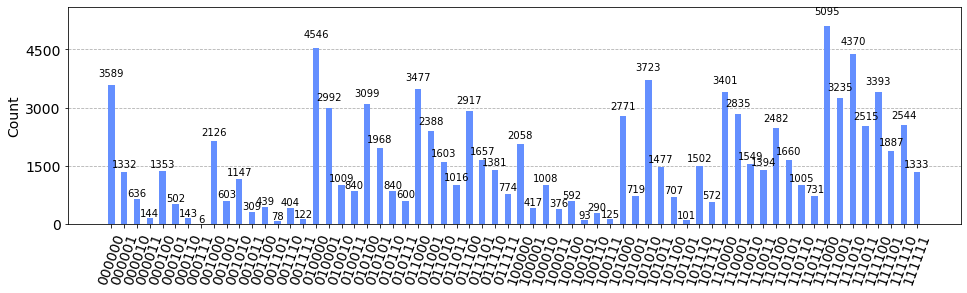

In [421]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.32321079591836 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.482692172118608


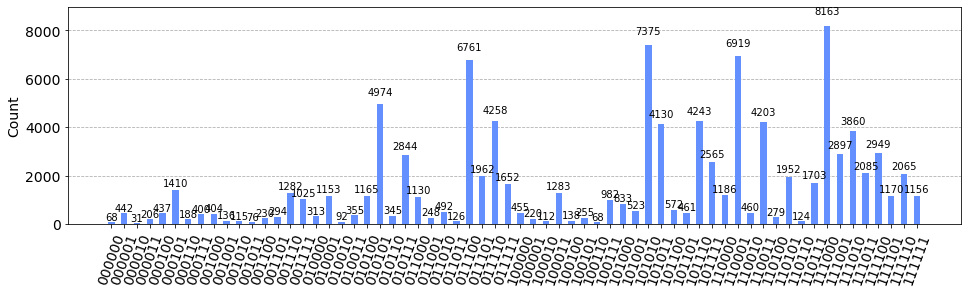

In [422]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Testing on fake noisy backend

In [444]:
simualtor = FakeToronto()

# Rx Mixer

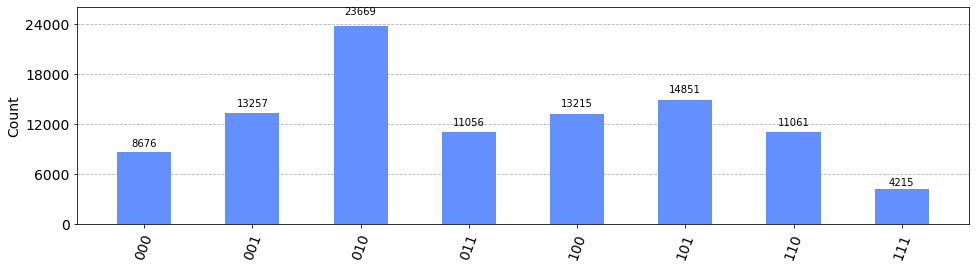

In [424]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.547353128995768 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.795386116498468


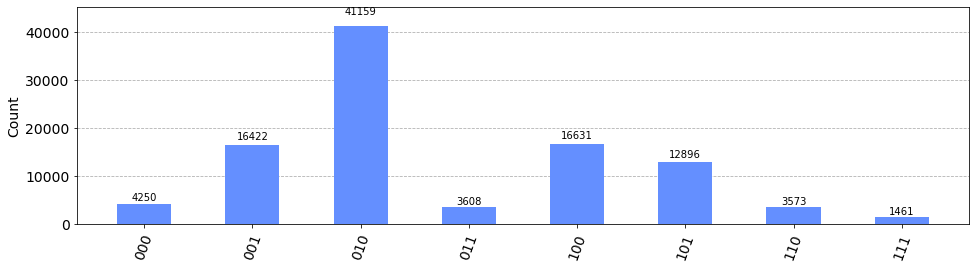

In [425]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

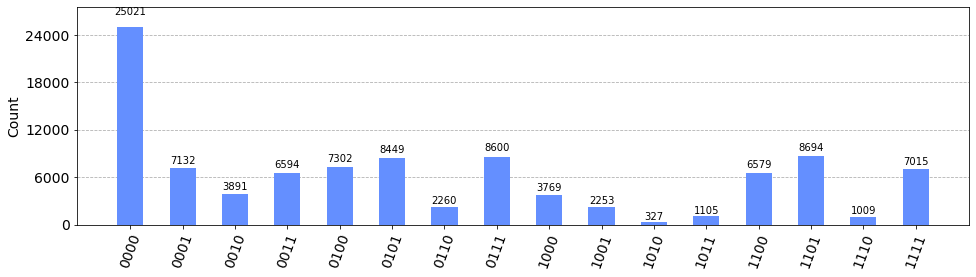

In [426]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.1436322776122698 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9144730370913217


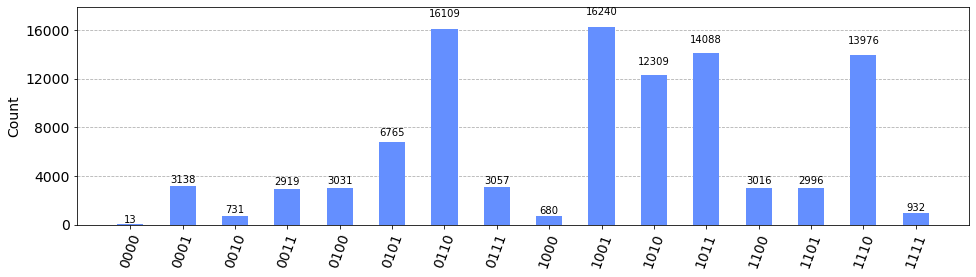

In [427]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

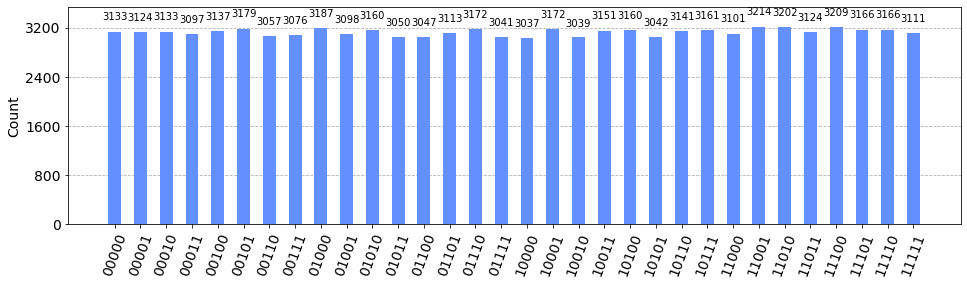

In [428]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 1.0083805055241286 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 0.43759736132613253


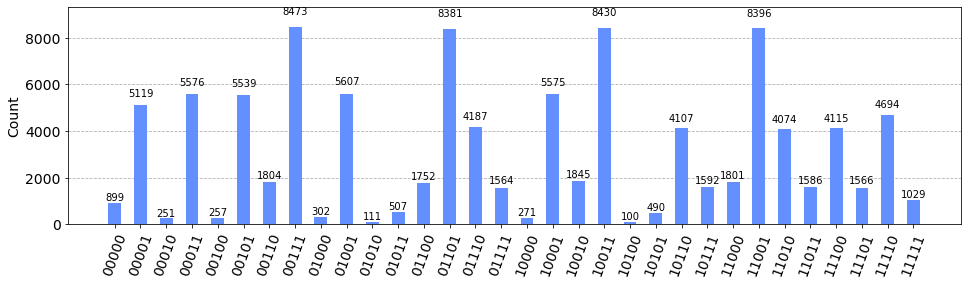

In [429]:
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

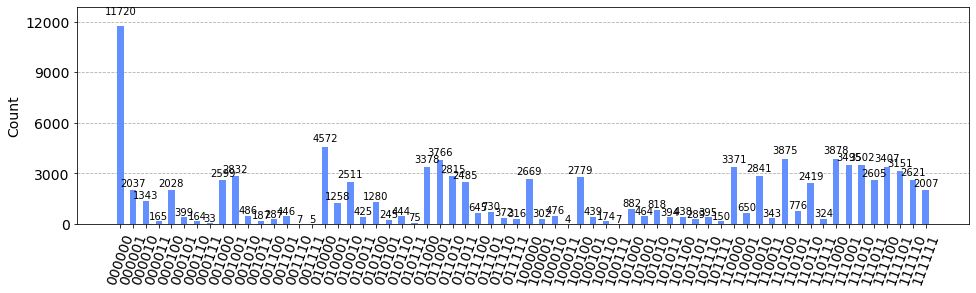

In [430]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 2.000087279128875 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 2.000048809360402


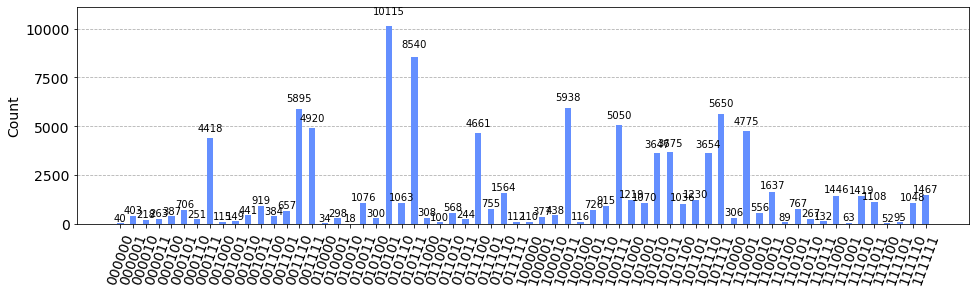

In [431]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Hadamard Mixer

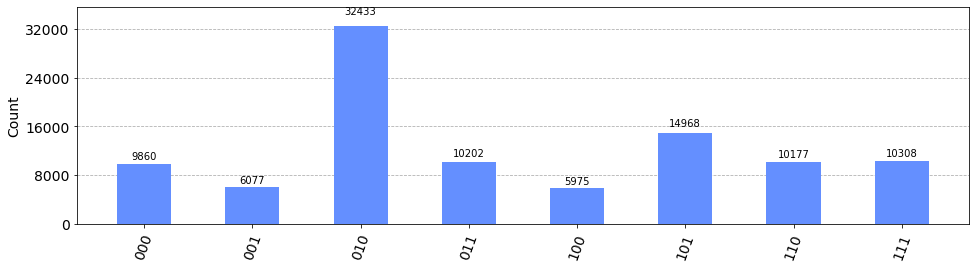

In [432]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.089726189867733 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.7924759784077517


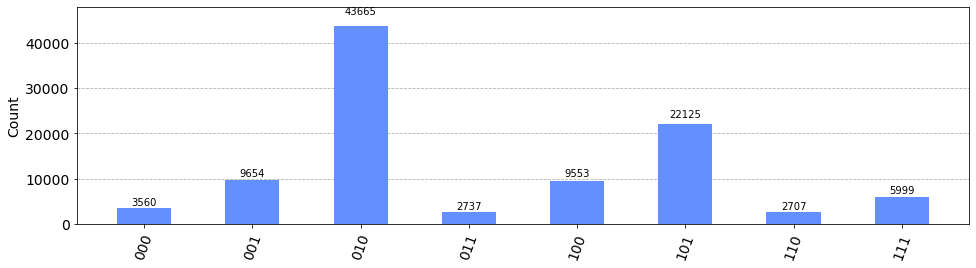

In [433]:
# 3 qubits
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_had(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

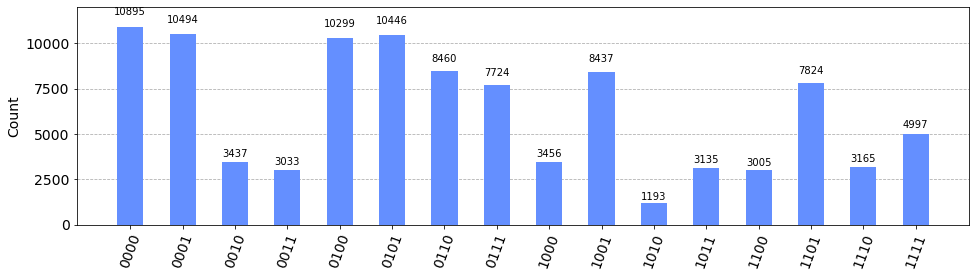

In [434]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [443]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

IBMQBackendApiError: "Error submitting job: '400 Client Error: Bad Request for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs. Error wrong data received., Error code: 2400.'"

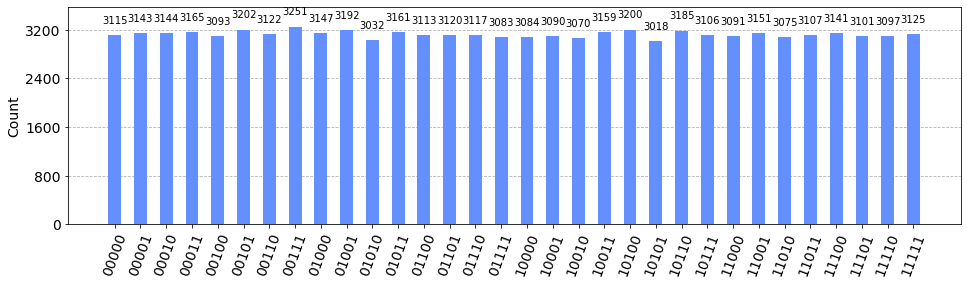

In [436]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [445]:
# 5 qubits
gamma=5
beta=2
theta = [gamma, beta]
expectation = get_expectation_had(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

IBMQBackendApiError: "Error submitting job: '400 Client Error: Bad Request for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs. Error wrong data received., Error code: 2400.'"

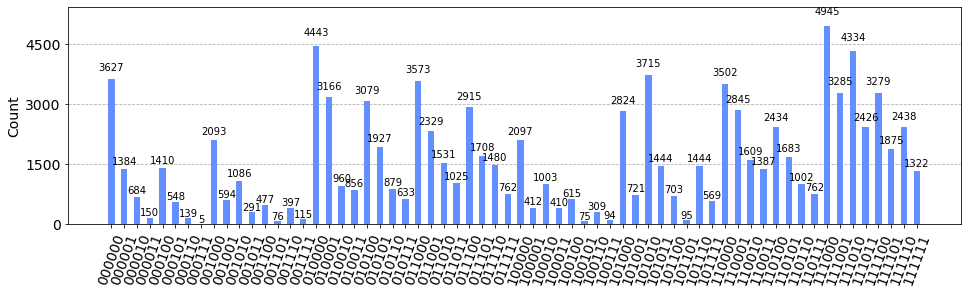

In [438]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.3950229673676338 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.1896520626121903


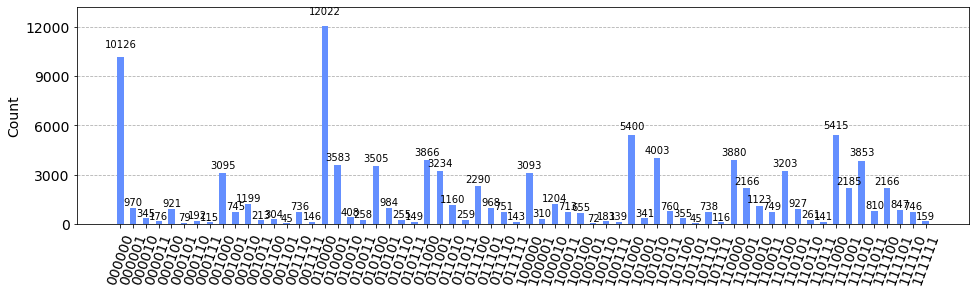

In [439]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

In [440]:
print(times["rx"])
print(times["had"])

{3: [0.20998358726501465, 0.26999759674072266], 4: [0.5509672164916992, 0.543001651763916], 5: [0.26596522331237793, 0.2970004081726074], 6: [0.33203125, 0.3399691581726074]}
{3: [0.20703792572021484, 0.20968103408813477], 4: [0.6639950275421143, 0.5259993076324463], 5: [0.2709994316101074, 0.2599606513977051], 6: [0.32599878311157227, 0.2830336093902588]}


# Testing on IBM quantum computer

In [441]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 7 and 
                                        not x.configuration().simulator and x.status().operational==True))
shots = backend.configuration().max_shots

# Rx mixer

In [442]:
# 3 qubit

gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

IBMQBackendApiError: "Error submitting job: '400 Client Error: Bad Request for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs. Error wrong data received., Error code: 2400.'"

In [ ]:
# 4 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 5 qubit

gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))


# Hadamard Mixer

In [ ]:
# 3 qubit

gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_had(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

In [ ]:
# 4 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 5 qubit

gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation_had(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))